In [20]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

In [4]:
# ---- (A) Load MBTA GTFS ----
stops = pd.read_csv("../../data/MBTA_GTFS/stops.txt")
stop_times = pd.read_csv("../../data/MBTA_GTFS/stop_times.txt")
trips = pd.read_csv("../../data/MBTA_GTFS/trips.txt")

# Convert stops to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(
    stops,
    geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
    crs="EPSG:4326"
)


C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\1024578489.py:3: DtypeWarning: Columns (0,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times = pd.read_csv("../../data/MBTA_GTFS/stop_times.txt")


In [5]:

# ---- (B) Load Census Tracts Shapefile ----
tracts = gpd.read_file("../../data/tl_2024_25_tract/tl_2024_25_tract.shp")
# Filter Massachusetts (FIPS = 25)
tracts = tracts[tracts["STATEFP"] == "25"]
boston_tracts = tracts[tracts["COUNTYFP"] == "025"].copy()
boston_tracts = boston_tracts[["GEOID", "geometry"]]



In [6]:
# Ensure CRS match
stops_gdf = stops_gdf.to_crs(boston_tracts.crs)
stops_boston = gpd.sjoin(stops_gdf, boston_tracts, how="inner", predicate="within")

In [7]:
# ---- (C) Load Race Demographics (ACS B03002 Data.csv) ----
race = pd.read_csv("../../data/B03002/Data.csv")

# Clean GEOID (remove "1400000US" prefix)
race["GEOID"] = race["GEO_ID"].str.replace("1400000US", "", regex=False)

# Keep relevant columns
race = race[[
    "GEOID",
    "B03002_001E",  # total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic/Latino
]]





In [8]:
print("Number of rows in race:", len(race))
print("Unique GEOIDs:", race['GEOID'].nunique())
print(race[['GEOID', 'B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E']].head(10))  # Check first 10 rows
print(race[['B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E']].describe())  # Should show varying mins/maxes/std if correct
print("Unique total populations:", race['B03002_001E'].nunique())  # Should be >1 if tract-level

Number of rows in race: 1621
Unique GEOIDs: 1621
         GEOID       B03002_001E  \
0    Geography  Estimate!!Total:   
1  25001010100              3681   
2  25001010206              4371   
3  25001010208              1675   
4  25001010304              2745   
5  25001010306              3027   
6  25001010400              3335   
7  25001010500              3007   
8  25001010600              3380   
9  25001010700              3263   

                                         B03002_003E  \
0  Estimate!!Total:!!Not Hispanic or Latino:!!Whi...   
1                                               2747   
2                                               3894   
3                                               1674   
4                                               2558   
5                                               2552   
6                                               3230   
7                                               2908   
8                                               31

In [9]:
# ===================================================
# 2. SPATIAL JOIN: Assign each MBTA stop to a census tract
# ===================================================

# Merge race onto tract shapes
boston_tracts = boston_tracts.merge(race, on="GEOID", how="left")
boston_tracts = boston_tracts.to_crs("EPSG:4326")  # ensure same CRS


race_cols = [
    "B03002_001E",  # Total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic
]

for col in race_cols:
    boston_tracts[col] = pd.to_numeric(boston_tracts[col], errors="coerce")


if "index_right" in stops_boston.columns:
    stops_boston = stops_boston.drop(columns="index_right")

if "index_right" in boston_tracts.columns:
    boston_tracts = boston_tracts.drop(columns="index_right")


stops_with_tract = gpd.sjoin(
    stops_boston,
    boston_tracts,
    how="left",
    predicate="within"
)


# Convert B03002 columns to numeric
race_cols = [
    "B03002_001E",  # Total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic
]

for col in race_cols:
    stops_with_tract[col] = pd.to_numeric(stops_with_tract[col], errors="coerce")



C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\947785563.py:29: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  stops_with_tract = gpd.sjoin(


In [10]:
# ===================================================
# 3. ASSIGN ROUTE DEMOGRAPHICS (aggregate stops → route)
# ===================================================

# join stop_times → stops_with_tract → trips
df = stop_times.merge(stops_with_tract, on="stop_id")
df = df.merge(trips[["trip_id", "route_id"]], on="trip_id")

# aggregate demographics for each route
route_demo = df.groupby("route_id").agg({
    "B03002_001E": "mean",
    "B03002_003E": "mean",
    "B03002_004E": "mean",
    "B03002_006E": "mean",
    "B03002_012E": "mean",
}).reset_index()

# compute race percentages (optional but recommended)
route_demo["pct_white"] = route_demo["B03002_003E"] / route_demo["B03002_001E"]
route_demo["pct_black"] = route_demo["B03002_004E"] / route_demo["B03002_001E"]
route_demo["pct_asian"] = route_demo["B03002_006E"] / route_demo["B03002_001E"]
route_demo["pct_hispanic"] = route_demo["B03002_012E"] / route_demo["B03002_001E"]

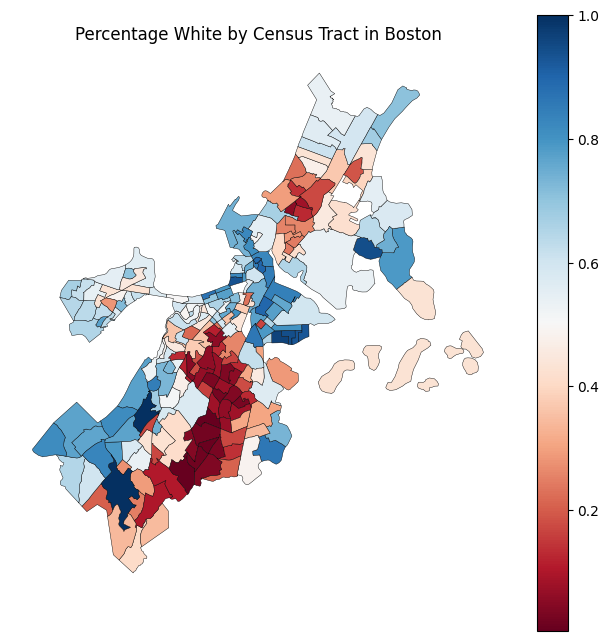

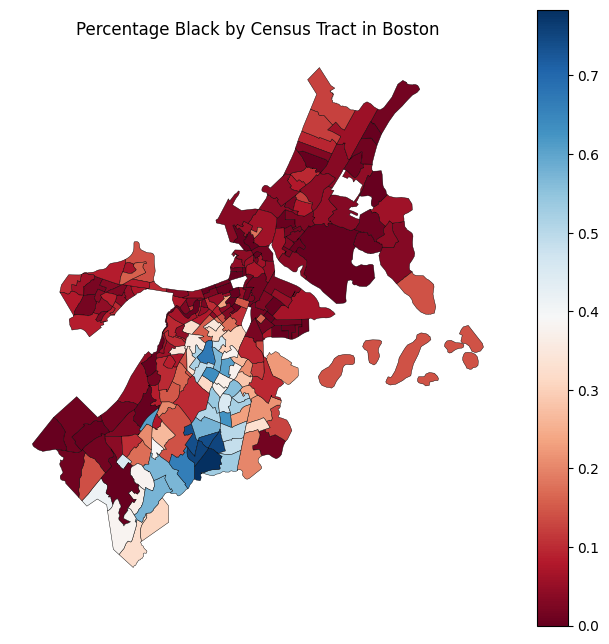

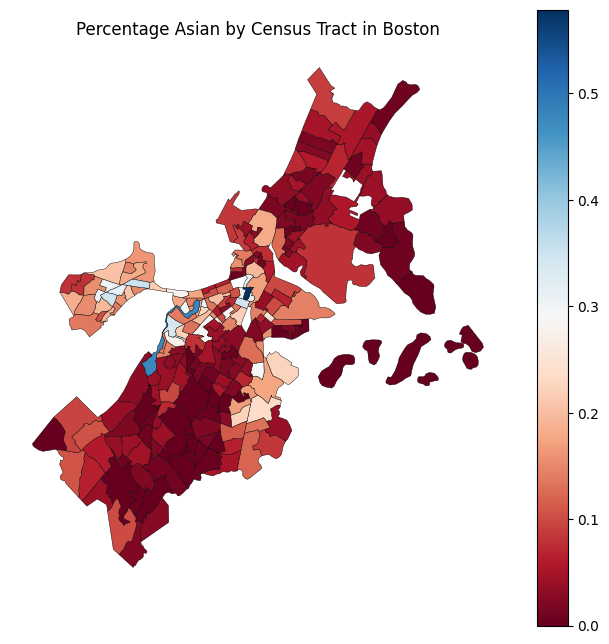

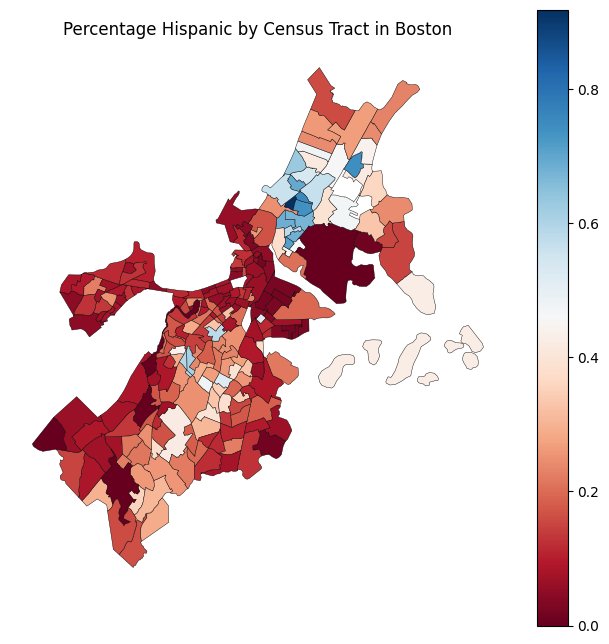

In [11]:
import matplotlib.pyplot as plt

# Define race percentage columns and labels
race_pct_cols = {
    "pct_white": "White",
    "pct_black": "Black",
    "pct_asian": "Asian",
    "pct_hispanic": "Hispanic"
}

# Compute percentages if not already done
boston_tracts["pct_white"] = boston_tracts["B03002_003E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_black"] = boston_tracts["B03002_004E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_asian"] = boston_tracts["B03002_006E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_hispanic"] = boston_tracts["B03002_012E"] / boston_tracts["B03002_001E"]

# Plot each race
for col, label in race_pct_cols.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    boston_tracts.plot(
        column=col,
        cmap="RdBu",      # Red → Blue colormap
        legend=True,
        ax=ax,
        edgecolor='black', # optional: outlines tracts
        linewidth=0.3
    )
    # boston_tracts.plot(ax=ax, cmap="RdBu", edgecolor='blue', linewidth=0.5, legend=True,column=col)
    plt.title(f"Percentage {label} by Census Tract in Boston")
    plt.axis("off")  # optional: remove axis
    plt.show()



In [21]:
boston_tracts.head()

,GEOID,geometry,B03002_001E,B03002_003E,B03002_004E,B03002_006E,B03002_012E,pct_white,pct_black,pct_asian,pct_hispanic
0,25025091300,"POLYGON ((-71.0722 42.32136, -71.07174 42.3214...",2687,341,716,78,726,0.126907,0.266468,0.029029,0.270190
1,25025110501,"POLYGON ((-71.14778 42.286, -71.14739 42.28601...",3204,2519,119,122,234,0.786205,0.037141,0.038077,0.073034
2,25025030500,"POLYGON ((-71.0598 42.36877, -71.05883 42.3692...",2219,1839,29,170,112,0.828752,0.013069,0.076611,0.050473
3,25025010500,"POLYGON ((-71.08776 42.3473, -71.08735 42.3474...",3241,1677,330,439,649,0.517433,0.101820,0.135452,0.200247
4,25025140201,"POLYGON ((-71.13924 42.23366, -71.13841 42.234...",2636,1072,852,58,432,0.406677,0.323217,0.022003,0.163885


Plot MBTA Stops and Tracts Together

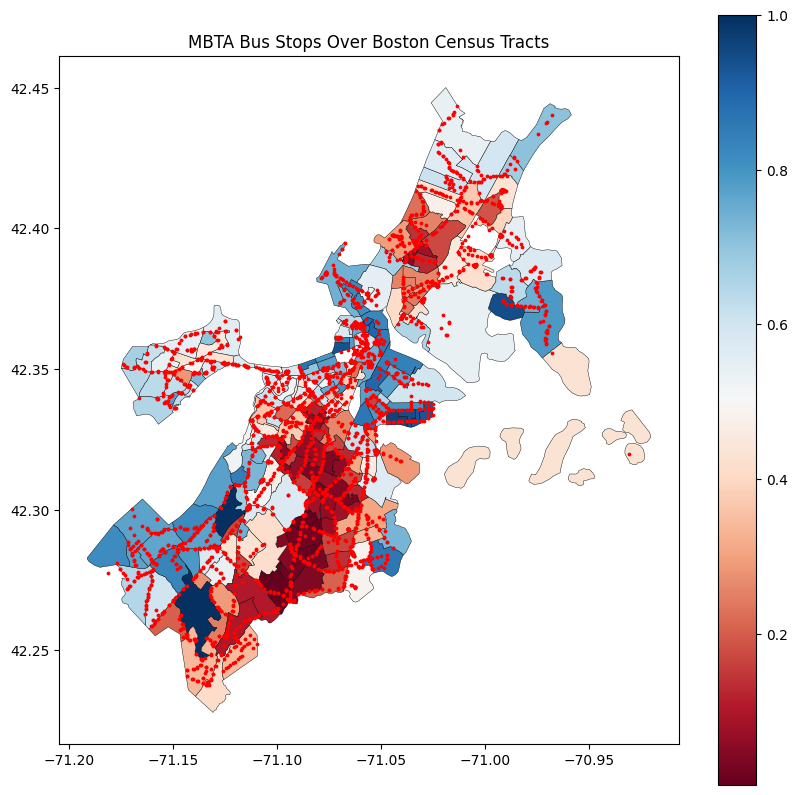

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
boston_tracts.plot(
        column="pct_white",
        cmap="RdBu",      # Red → Blue colormap
        legend=True,
        ax=ax,
        edgecolor='black', # optional: outlines tracts
        linewidth=0.3
    )
# boston_tracts.plot(ax=ax, color='lightgray', edgecolor='blue', linewidth=0.5,cmap="RdBu",column ="pct_white" )  # Plots filled tracts with outlines
stops_boston.plot(ax=ax, color='red', markersize=3)
ax.set_title("MBTA Bus Stops Over Boston Census Tracts")
plt.show()

Check demographic distribution for the stops

In [23]:
stops_with_tract[["B03002_003E","B03002_004E","B03002_006E","B03002_012E"]].describe()


,B03002_003E,B03002_004E,B03002_006E,B03002_012E
count,3374.000000,3374.000000,3374.000000,3374.000000
mean,1720.417309,676.909306,350.882039,851.256372
std,1120.762455,1034.917690,348.391211,863.272457
min,0.000000,0.000000,0.000000,0.000000
25%,979.500000,75.000000,78.000000,239.000000
50%,1572.000000,215.000000,243.000000,529.000000
75%,2595.000000,734.000000,564.000000,1233.000000
max,5097.000000,4992.000000,2394.000000,5654.000000


Visualize Distribution of Race Percentages Across Stops

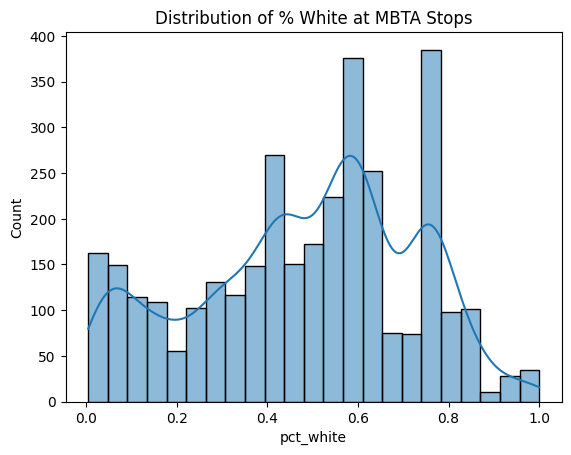

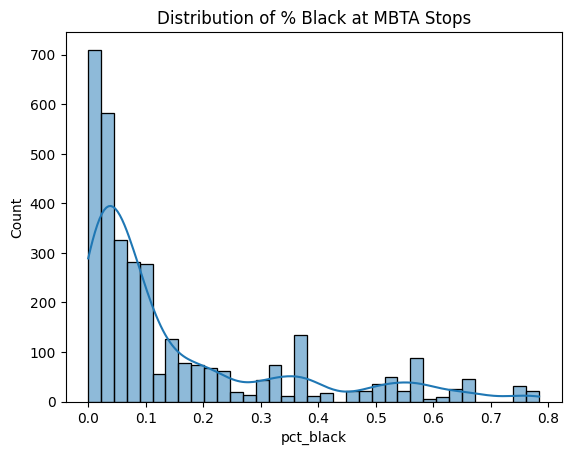

In [24]:


# Ensure B03002 columns are numeric
race_cols = ["B03002_001E","B03002_003E","B03002_004E","B03002_006E","B03002_012E"]

for col in race_cols:
    stops_with_tract[col] = pd.to_numeric(stops_with_tract[col], errors="coerce")

# Compute race percentages
stops_with_tract["pct_white"] = stops_with_tract["B03002_003E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_black"] = stops_with_tract["B03002_004E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_asian"] = stops_with_tract["B03002_006E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_hispanic"] = stops_with_tract["B03002_012E"] / stops_with_tract["B03002_001E"]


sns.histplot(stops_with_tract["pct_white"], kde=True)
plt.title("Distribution of % White at MBTA Stops")
plt.show()

sns.histplot(stops_with_tract["pct_black"], kde=True)
plt.title("Distribution of % Black at MBTA Stops")
plt.show()

In [25]:
stops_with_tract.head()

,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,...,GEOID_right,B03002_001E,B03002_003E,B03002_004E,B03002_006E,B03002_012E,pct_white,pct_black,pct_asian,pct_hispanic
0,1,1.0,Washington St opp Ruggles St,NaN,NaN,NaN,42.330957,-71.082754,ExpressBus-Downtown,NaN,...,25025080401,3109,178,978,120,1804,0.057253,0.314571,0.038598,0.580251
1,10,10.0,Theo Glynn Way @ Newmarket Sq,NaN,NaN,NaN,42.330555,-71.068787,LocalBus,NaN,...,25025080100,2593,669,779,74,651,0.258002,0.300424,0.028538,0.251061
2,10000,10000.0,Tremont St opp Temple Pl,NaN,NaN,NaN,42.355692,-71.062911,LocalBus,NaN,...,25025981700,0,0,0,0,0,NaN,NaN,NaN,NaN
3,10003,10003.0,Albany St opp Randall St,NaN,NaN,NaN,42.331591,-71.076237,LocalBus,NaN,...,25025080100,2593,669,779,74,651,0.258002,0.300424,0.028538,0.251061
4,10005,10005.0,Albany St opp E Concord St,NaN,NaN,NaN,42.335017,-71.071280,LocalBus,NaN,...,25025071101,3758,2049,650,547,306,0.545237,0.172964,0.145556,0.081426


Bar Chart of Demographics by Route

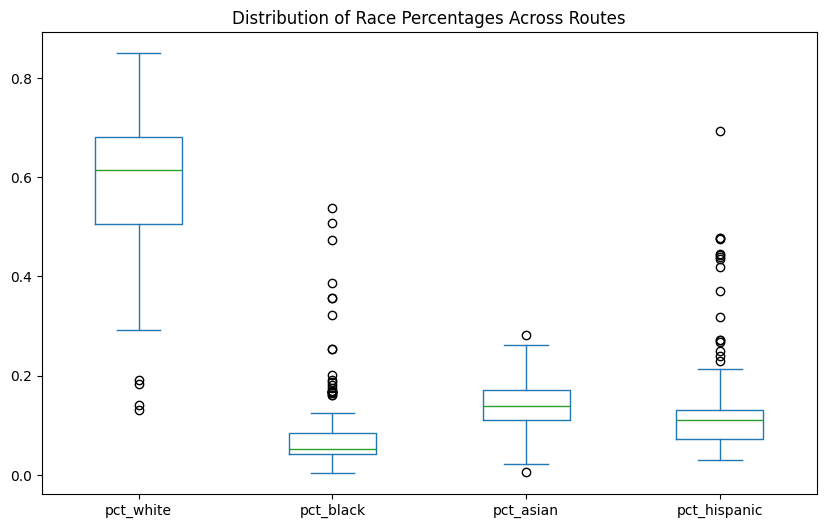

In [26]:
route_demo[["pct_white","pct_black","pct_asian","pct_hispanic"]].plot(
    kind="box",
    figsize=(10,6)
)
plt.title("Distribution of Race Percentages Across Routes")
plt.show()


Scatterplots: Race vs. Headway or Ridership (if available later)

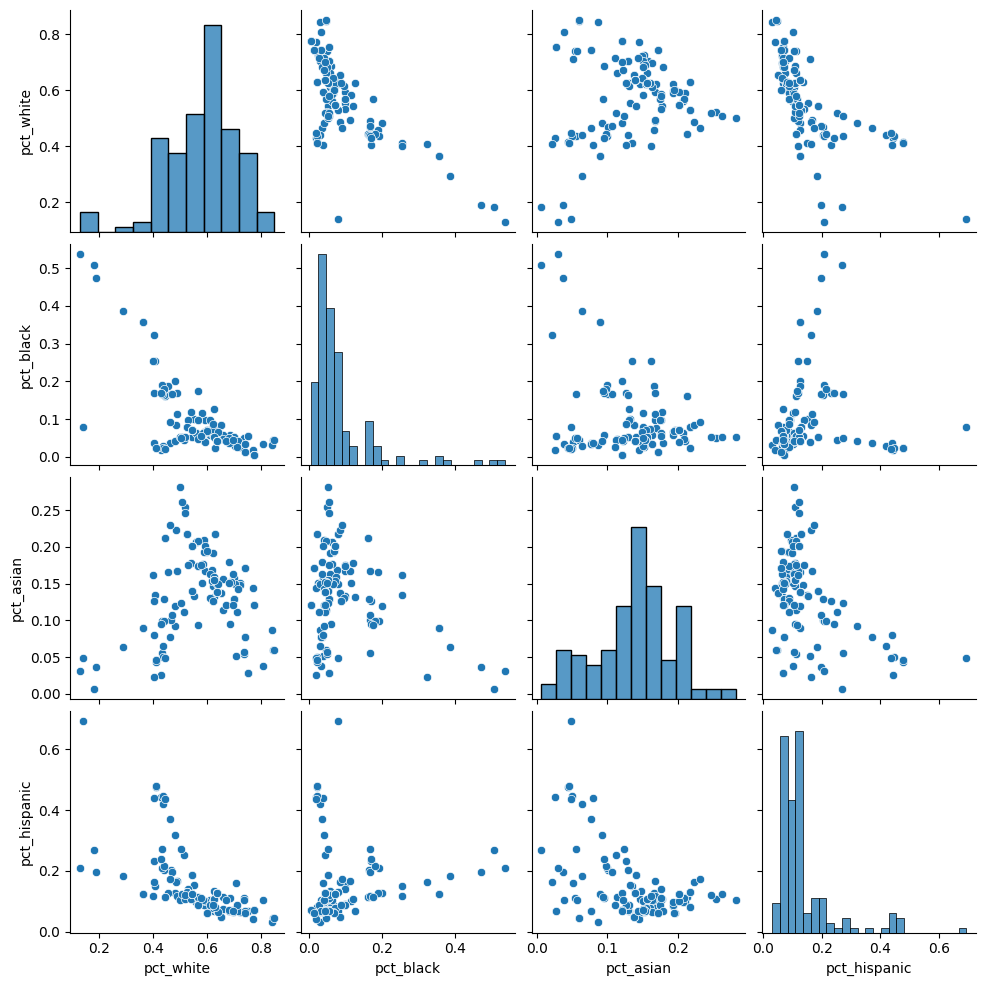

In [27]:
sns.pairplot(
    route_demo[["pct_white","pct_black","pct_asian","pct_hispanic"]],
    kind="scatter"
)
plt.show()


In [30]:


# Load the parquet file
arrival = pd.read_parquet("../../data/MBTA_Bus_Parquet/MBTA_Bus_Arrival_Departure_Times_2024.parquet", engine="fastparquet")

# Quick look at the data
print(arrival.columns)
print(arrival.head())
print(arrival.dtypes)


Index(['service_date', 'route_id', 'direction_id', 'half_trip_id', 'stop_id',
       'time_point_id', 'time_point_order', 'point_type', 'standard_type',
       'scheduled', 'actual', 'scheduled_headway', 'headway'],
      dtype='object')
  service_date route_id direction_id  half_trip_id  stop_id time_point_id  \
0   2024-01-01       01      Inbound    61824022.0      110         hhgat   
1   2024-01-01       01      Inbound    61824022.0       67         maput   
2   2024-01-01       01      Inbound    61824022.0       72         cntsq   
3   2024-01-01       01      Inbound    61824022.0       75           mit   
4   2024-01-01       01      Inbound    61824022.0       79         hynes   

   time_point_order  point_type standard_type             scheduled  \
0                 1  Startpoint      Schedule  1900-01-01T06:05:00Z   
1                 2    Midpoint      Schedule  1900-01-01T06:09:00Z   
2                 3    Midpoint      Schedule  1900-01-01T06:12:00Z   
3              

In [31]:
# Convert to datetime if needed
arrival['scheduled'] = pd.to_datetime(arrival['scheduled'])
arrival['actual'] = pd.to_datetime(arrival['actual'])

# Compute lateness in minutes
arrival['lateness'] = (arrival['actual'] - arrival['scheduled']).dt.total_seconds() / 60

# Clip negative lateness to 0 if you only care about being late
arrival['lateness'] = arrival['lateness'].clip(lower=0)

Average lateness per stop and route

In [32]:
avg_lateness = arrival.groupby(['route_id', 'stop_id']).agg({
    'lateness': 'mean',
    'scheduled_headway': 'mean'  # optional operational feature
}).reset_index()


C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\400907245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_lateness = arrival.groupby(['route_id', 'stop_id']).agg({


Merge with stop demographics

In [33]:
avg_lateness['stop_id'] = avg_lateness['stop_id'].astype(str)
stops_with_tract['stop_id'] = stops_with_tract['stop_id'].astype(str)

lateness_demo = avg_lateness.merge(
    stops_with_tract[['stop_id', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic','B03002_001E',	'B03002_003E',	'B03002_004E',	'B03002_006E',	'B03002_012E']],
    on='stop_id',
    how='left'
)
lateness_demo = lateness_demo.dropna(
    subset=['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic','lateness']
)


In [34]:
# stops_with_tract.value_counts('stop_id')
lateness_demo.head()

,route_id,stop_id,lateness,scheduled_headway,pct_white,pct_black,pct_asian,pct_hispanic,B03002_001E,B03002_003E,B03002_004E,B03002_006E,B03002_012E
0,01,2,5.184662,775.287403,0.057253,0.314571,0.038598,0.580251,3109.0,178.0,978.0,120.0,1804.0
13,01,59,8.624564,793.700574,0.545237,0.172964,0.145556,0.081426,3758.0,2049.0,650.0,547.0,306.0
14,01,62,8.932083,793.462834,0.057253,0.314571,0.038598,0.580251,3109.0,178.0,978.0,120.0,1804.0
15,01,64,5.391084,781.704581,0.358454,0.154289,0.285284,0.138942,3649.0,1308.0,563.0,1041.0,507.0
20,01,79,8.279389,793.669493,0.580009,0.054912,0.175032,0.110682,4662.0,2704.0,256.0,816.0,516.0


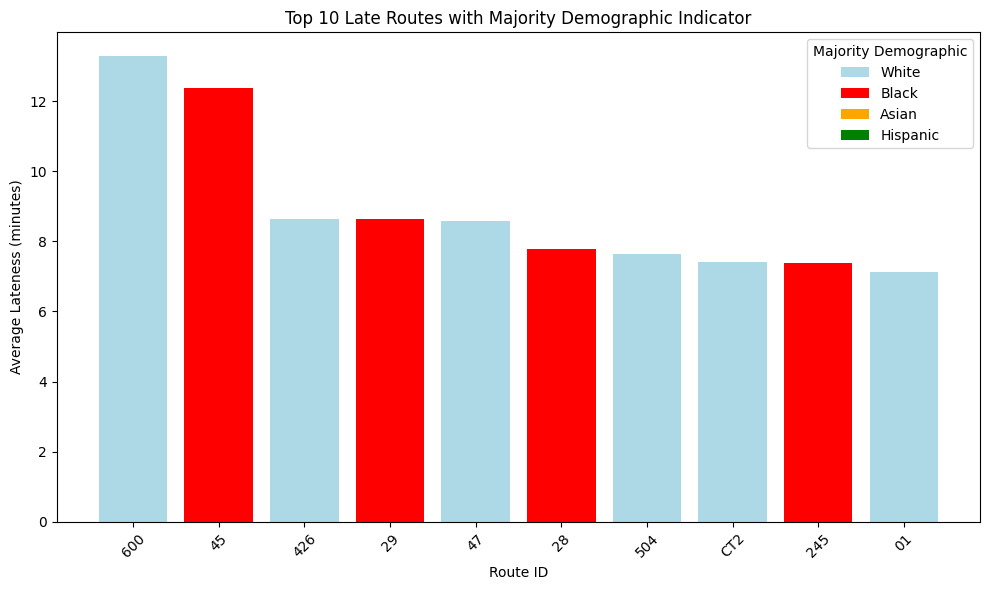

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Copy your DataFrame
df = lateness_demo.copy()

# 1️⃣ Aggregate: average lateness per route
route_lateness = df.groupby('route_id', observed=True)['lateness'].mean().reset_index()

# 2️⃣ Get top 10 late routes
top_10_routes = route_lateness.sort_values(by='lateness', ascending=False).head(10)

# 3️⃣ Determine majority demographic per route
route_demo = df.groupby('route_id', observed=True)[['pct_white','pct_black','pct_asian','pct_hispanic']].mean().reset_index()
top_10 = top_10_routes.merge(route_demo, on='route_id')

def majority_demo(row):
    demo_cols = ['pct_white','pct_black','pct_asian','pct_hispanic']
    return row[demo_cols].idxmax().replace('pct_','').capitalize()

top_10['majority_demo'] = top_10.apply(majority_demo, axis=1)

# 4️⃣ Define colors for demographics
demo_colors = {'White':'lightblue', 'Black':'red', 'Asian':'orange', 'Hispanic':'green'}
top_10['color'] = top_10['majority_demo'].map(demo_colors)

# 5️⃣ Plot using matplotlib directly (avoids sns palette issue)
plt.figure(figsize=(10,6))
bars = plt.bar(top_10['route_id'], top_10['lateness'], color=top_10['color'])

plt.xlabel("Route ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Late Routes with Majority Demographic Indicator")
plt.xticks(rotation=45)

# Add legend manually
legend_elements = [Patch(facecolor=color, label=demo) for demo, color in demo_colors.items()]
plt.legend(handles=legend_elements, title="Majority Demographic")

plt.tight_layout()
plt.show()


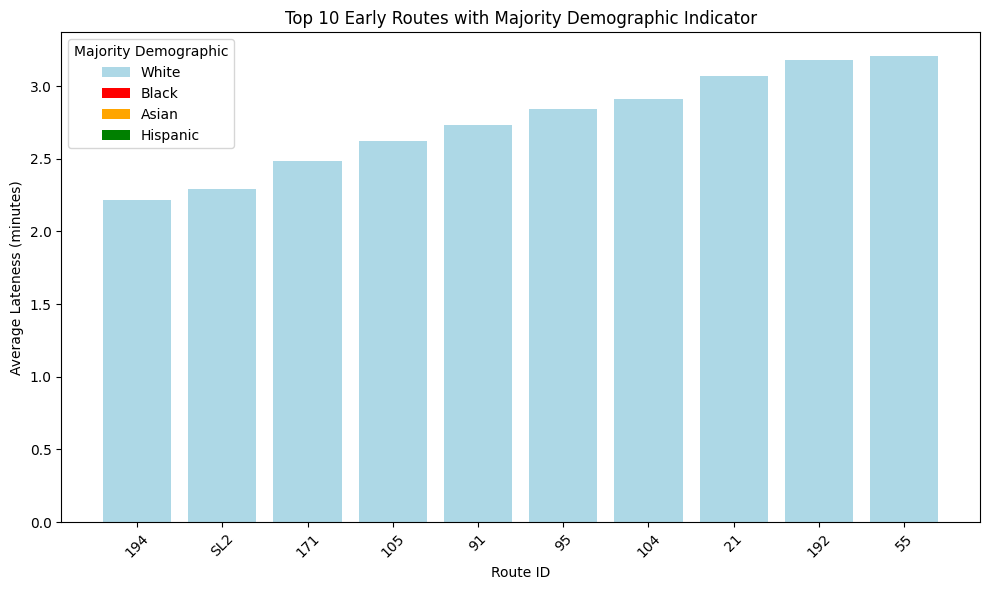

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Copy your DataFrame
df = lateness_demo.copy()

# 1️⃣ Aggregate: average lateness per route
route_lateness = df.groupby('route_id', observed=True)['lateness'].mean().reset_index()

# 2️⃣ Get top 10 early routes (lowest lateness)
top_10_early_routes = route_lateness.sort_values(by='lateness', ascending=True).head(10)

# 3️⃣ Determine majority demographic per route
route_demo = df.groupby('route_id', observed=True)[['pct_white','pct_black','pct_asian','pct_hispanic']].mean().reset_index()
top_10_early = top_10_early_routes.merge(route_demo, on='route_id')

def majority_demo(row):
    demo_cols = ['pct_white','pct_black','pct_asian','pct_hispanic']
    return row[demo_cols].idxmax().replace('pct_','').capitalize()

top_10_early['majority_demo'] = top_10_early.apply(majority_demo, axis=1)

# 4️⃣ Define colors for demographics
demo_colors = {'White':'lightblue', 'Black':'red', 'Asian':'orange', 'Hispanic':'green'}
top_10_early['color'] = top_10_early['majority_demo'].map(demo_colors)

# 5️⃣ Plot using matplotlib
plt.figure(figsize=(10,6))
bars = plt.bar(top_10_early['route_id'], top_10_early['lateness'], color=top_10_early['color'])

plt.xlabel("Route ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Early Routes with Majority Demographic Indicator")
plt.xticks(rotation=45)

# Add legend manually
legend_elements = [Patch(facecolor=color, label=demo) for demo, color in demo_colors.items()]
plt.legend(handles=legend_elements, title="Majority Demographic")

plt.tight_layout()
plt.show()


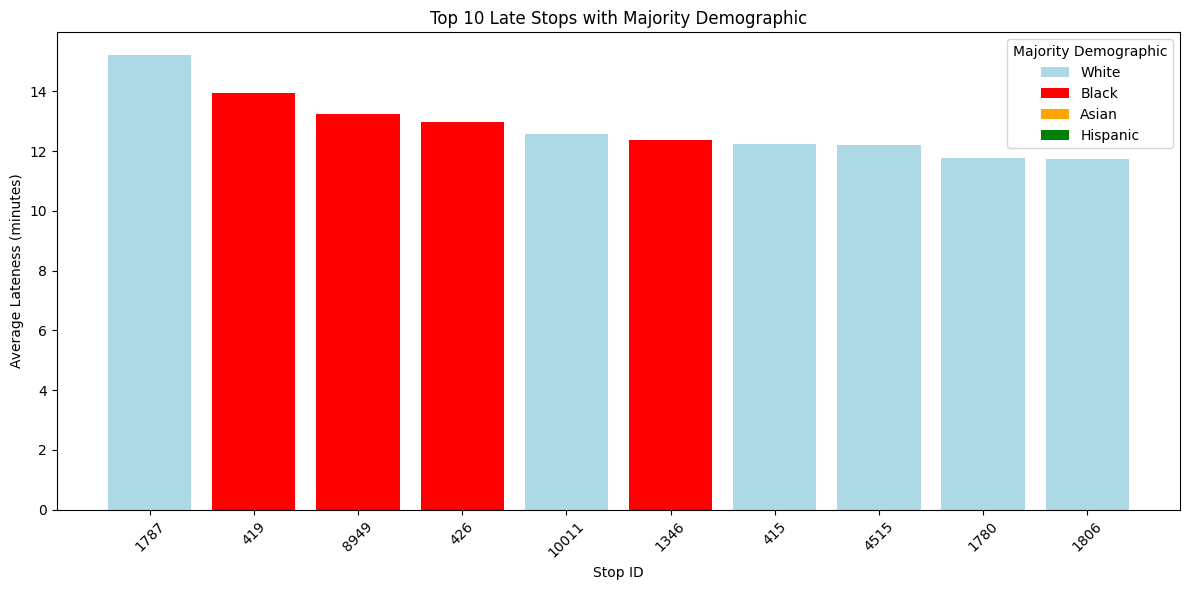

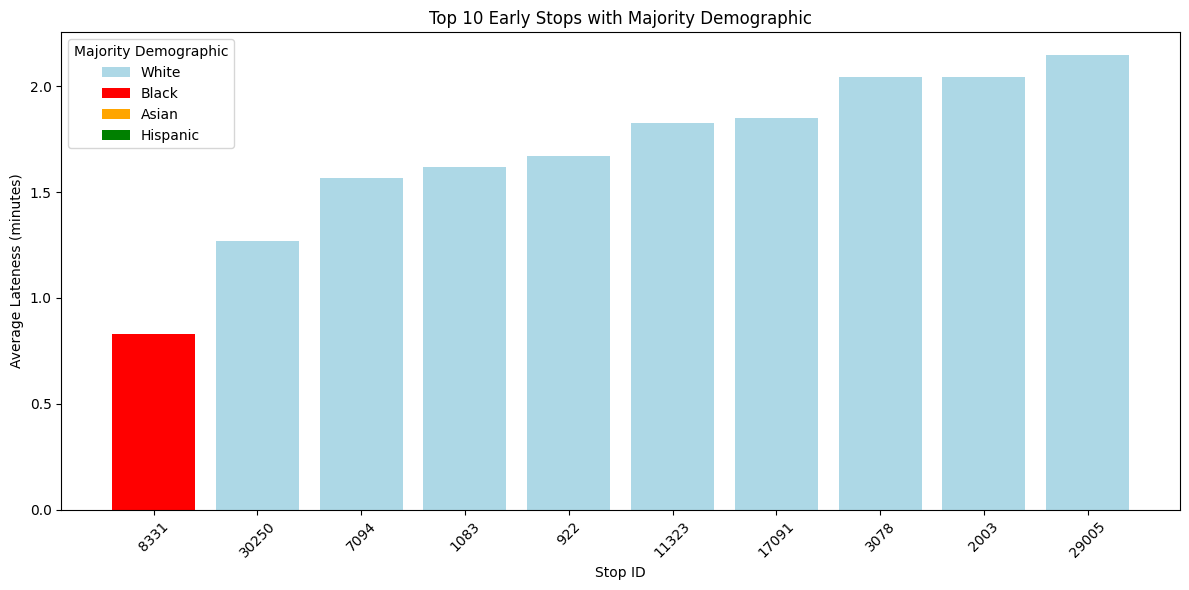

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Copy your DataFrame
df = lateness_demo.copy()

# Define colors for demographics
demo_colors = {'White':'lightblue', 'Black':'red', 'Asian':'orange', 'Hispanic':'green'}

# Function to determine majority demographic
def majority_demo(row):
    demo_cols = ['pct_white','pct_black','pct_asian','pct_hispanic']
    return row[demo_cols].idxmax().replace('pct_','').capitalize()

# ------------------------------
# Top 10 Late Stops
# ------------------------------
stop_lateness = df.groupby('stop_id', observed=True)['lateness'].mean().reset_index()
top_10_late_stops = stop_lateness.sort_values(by='lateness', ascending=False).head(10)

# Merge with demographic info
stop_demo = df.groupby('stop_id', observed=True)[['pct_white','pct_black','pct_asian','pct_hispanic']].mean().reset_index()
top_10_late_stops = top_10_late_stops.merge(stop_demo, on='stop_id')
top_10_late_stops['majority_demo'] = top_10_late_stops.apply(majority_demo, axis=1)
top_10_late_stops['color'] = top_10_late_stops['majority_demo'].map(demo_colors)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top_10_late_stops['stop_id'], top_10_late_stops['lateness'], color=top_10_late_stops['color'])
plt.xlabel("Stop ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Late Stops with Majority Demographic")
plt.xticks(rotation=45)
legend_elements = [Patch(facecolor=color, label=demo) for demo, color in demo_colors.items()]
plt.legend(handles=legend_elements, title="Majority Demographic")
plt.tight_layout()
plt.show()


# ------------------------------
# Top 10 Early Stops
# ------------------------------
top_10_early_stops = stop_lateness.sort_values(by='lateness', ascending=True).head(10)
top_10_early_stops = top_10_early_stops.merge(stop_demo, on='stop_id')
top_10_early_stops['majority_demo'] = top_10_early_stops.apply(majority_demo, axis=1)
top_10_early_stops['color'] = top_10_early_stops['majority_demo'].map(demo_colors)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top_10_early_stops['stop_id'], top_10_early_stops['lateness'], color=top_10_early_stops['color'])
plt.xlabel("Stop ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Early Stops with Majority Demographic")
plt.xticks(rotation=45)
plt.legend(handles=legend_elements, title="Majority Demographic")
plt.tight_layout()
plt.show()


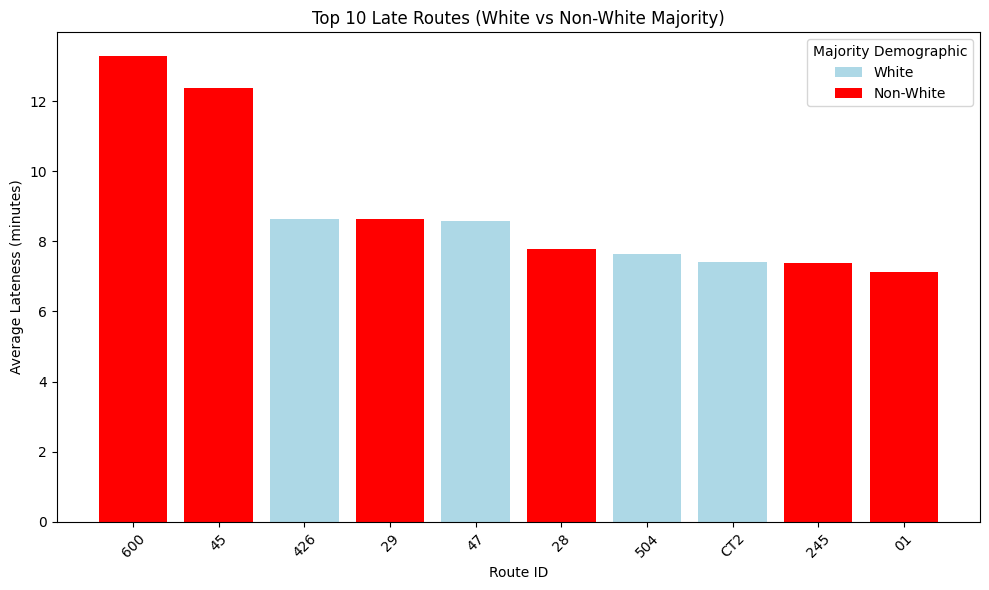

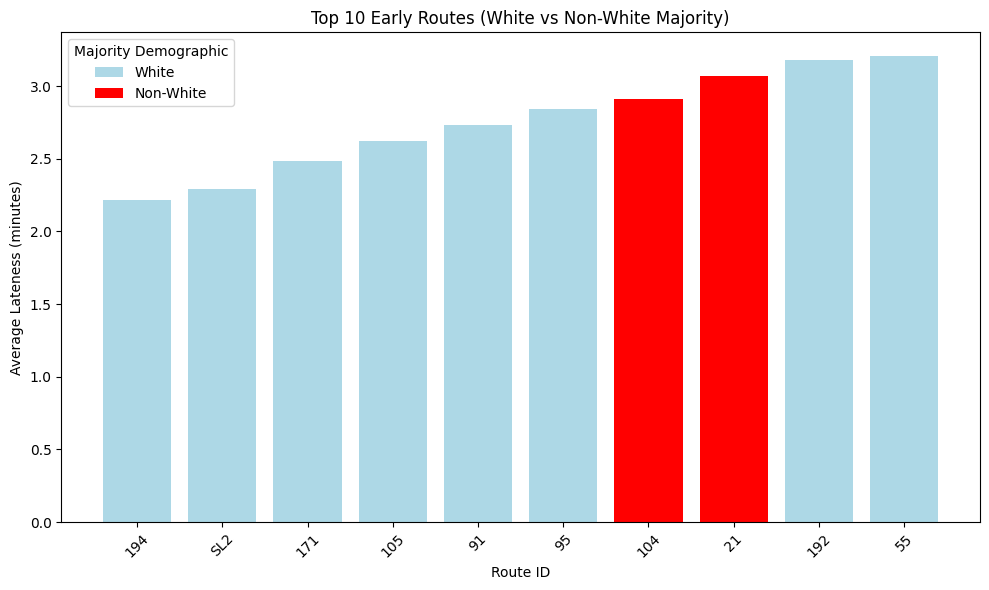

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = lateness_demo.copy()

# Compute pct_nonwhite
df['pct_nonwhite'] = 1 - df['pct_white']

# Define colors for White vs Non-White
demo_colors = {'White':'lightblue', 'Non-White':'red'}

# Function to assign majority
def majority_white_nonwhite(row):
    return 'White' if row['pct_white'] > 0.5 else 'Non-White'

# ------------------------------
# Top 10 Late Routes
# ------------------------------
route_lateness = df.groupby('route_id', observed=True)['lateness'].mean().reset_index()
top_10_late_routes = route_lateness.sort_values(by='lateness', ascending=False).head(10)

# Compute average pct_white per route
route_demo = df.groupby('route_id', observed=True)[['pct_white']].mean().reset_index()
top_10_late_routes = top_10_late_routes.merge(route_demo, on='route_id')

# Assign majority
top_10_late_routes['majority_demo'] = top_10_late_routes.apply(majority_white_nonwhite, axis=1)
top_10_late_routes['color'] = top_10_late_routes['majority_demo'].map(demo_colors)

# Plot
plt.figure(figsize=(10,6))
plt.bar(top_10_late_routes['route_id'], top_10_late_routes['lateness'], color=top_10_late_routes['color'])
plt.xlabel("Route ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Late Routes (White vs Non-White Majority)")
plt.xticks(rotation=45)
legend_elements = [Patch(facecolor=color, label=demo) for demo, color in demo_colors.items()]
plt.legend(handles=legend_elements, title="Majority Demographic")
plt.tight_layout()
plt.show()


# ------------------------------
# Top 10 Early Routes
# ------------------------------
top_10_early_routes = route_lateness.sort_values(by='lateness', ascending=True).head(10)
top_10_early_routes = top_10_early_routes.merge(route_demo, on='route_id')
top_10_early_routes['majority_demo'] = top_10_early_routes.apply(majority_white_nonwhite, axis=1)
top_10_early_routes['color'] = top_10_early_routes['majority_demo'].map(demo_colors)

# Plot
plt.figure(figsize=(10,6))
plt.bar(top_10_early_routes['route_id'], top_10_early_routes['lateness'], color=top_10_early_routes['color'])
plt.xlabel("Route ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Early Routes (White vs Non-White Majority)")
plt.xticks(rotation=45)
plt.legend(handles=legend_elements, title="Majority Demographic")
plt.tight_layout()
plt.show()


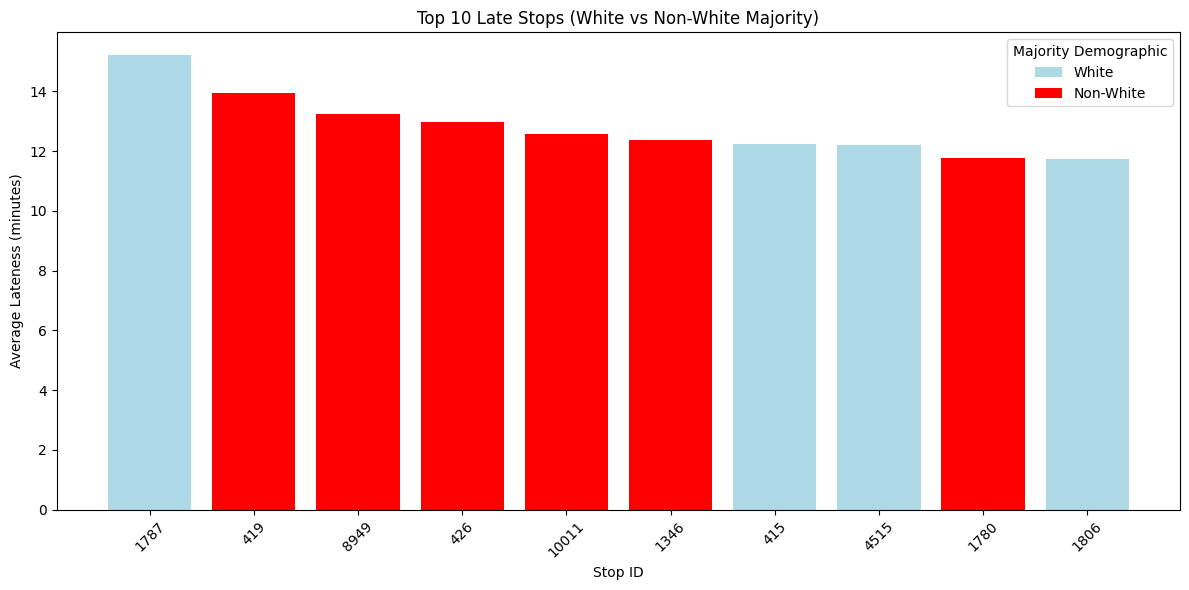

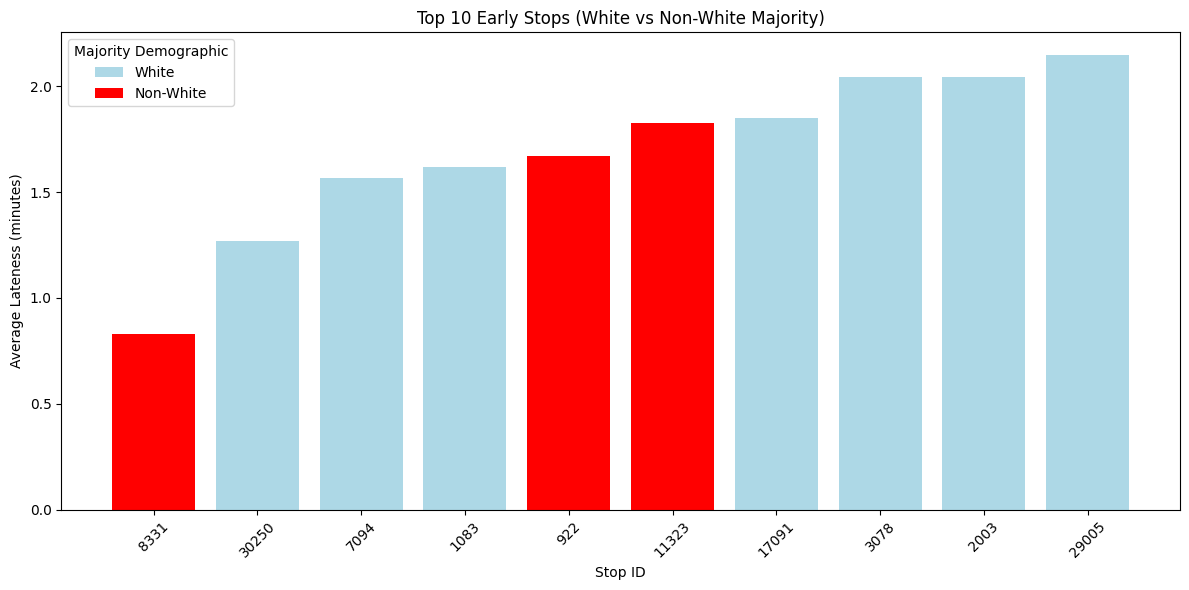

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Copy your DataFrame
df = lateness_demo.copy()

# Compute pct_nonwhite
df['pct_nonwhite'] = 1 - df['pct_white']

# Define colors for White vs Non-White
demo_colors = {'White':'lightblue', 'Non-White':'red'}

# Function to assign majority
def majority_white_nonwhite(row):
    return 'White' if row['pct_white'] > 0.5 else 'Non-White'

# ------------------------------
# Aggregate lateness per stop
# ------------------------------
stop_lateness = df.groupby('stop_id', observed=True)['lateness'].mean().reset_index()

# Compute average pct_white per stop
stop_demo = df.groupby('stop_id', observed=True)[['pct_white']].mean().reset_index()

# ------------------------------
# Top 10 Late Stops
# ------------------------------
top_10_late_stops = stop_lateness.sort_values(by='lateness', ascending=False).head(10)
top_10_late_stops = top_10_late_stops.merge(stop_demo, on='stop_id')
top_10_late_stops['majority_demo'] = top_10_late_stops.apply(majority_white_nonwhite, axis=1)
top_10_late_stops['color'] = top_10_late_stops['majority_demo'].map(demo_colors)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top_10_late_stops['stop_id'], top_10_late_stops['lateness'], color=top_10_late_stops['color'])
plt.xlabel("Stop ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Late Stops (White vs Non-White Majority)")
plt.xticks(rotation=45)
legend_elements = [Patch(facecolor=color, label=demo) for demo, color in demo_colors.items()]
plt.legend(handles=legend_elements, title="Majority Demographic")
plt.tight_layout()
plt.show()


# ------------------------------
# Top 10 Early Stops
# ------------------------------
top_10_early_stops = stop_lateness.sort_values(by='lateness', ascending=True).head(10)
top_10_early_stops = top_10_early_stops.merge(stop_demo, on='stop_id')
top_10_early_stops['majority_demo'] = top_10_early_stops.apply(majority_white_nonwhite, axis=1)
top_10_early_stops['color'] = top_10_early_stops['majority_demo'].map(demo_colors)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top_10_early_stops['stop_id'], top_10_early_stops['lateness'], color=top_10_early_stops['color'])
plt.xlabel("Stop ID")
plt.ylabel("Average Lateness (minutes)")
plt.title("Top 10 Early Stops (White vs Non-White Majority)")
plt.xticks(rotation=45)
plt.legend(handles=legend_elements, title="Majority Demographic")
plt.tight_layout()
plt.show()


\begin{align*}
\text{pct_underserved_white} &= \frac{\text{total underserved white population across all stops}}{\text{total white population in Boston}} \times 100 \\
\text{pct_underserved_black} &= \frac{\text{total underserved black population across all stops}}{\text{total black population in Boston}} \times 100 \\
\text{pct_underserved_hispanic} &= \frac{\text{total underserved hispanic population across all stops}}{\text{total hispanic population in Boston}} \times 100 \\
\text{pct_underserved_asian} &= \frac{\text{total underserved asian population across all stops}}{\text{total asian population in Boston}} \times 100
\end{align*}

In [40]:
import pandas as pd

df = lateness_demo.copy()

# 1️⃣ Set lateness threshold (define underserved)
threshold = 8  # minutes

# 2️⃣ Create indicator column: 1 if stop is underserved
df['underserved'] = (df['lateness'] > threshold).astype(int)

# 3️⃣ Compute number of underserved per racial group at each stop
df['underserved_white'] = df['B03002_003E'] * df['underserved']
df['underserved_black'] = df['B03002_004E'] * df['underserved']
df['underserved_hispanic'] = df['B03002_012E'] * df['underserved']
df['underserved_asian'] = df['B03002_006E'] * df['underserved']


# 4️⃣ Total underserved per group
total_underserved_white = df['underserved_white'].sum()
total_underserved_black = df['underserved_black'].sum()
total_underserved_hispanic = df['underserved_hispanic'].sum()
total_underserved_asian = df['underserved_asian'].sum()

# 5️⃣ Total population per group in Boston
total_white = df['B03002_003E'].sum()
total_black = df['B03002_004E'].sum()
total_hispanic = df['B03002_012E'].sum()
total_asian = df['B03002_006E'].sum()

# 6️⃣ Compute percentages
pct_underserved_white = (total_underserved_white / total_white) * 100
pct_underserved_black = (total_underserved_black / total_black) * 100
pct_underserved_hispanic = (total_underserved_hispanic / total_hispanic) * 100
pct_underserved_asian = (total_underserved_asian / total_asian) * 100

print(f"Percentage of White population underserved: {pct_underserved_white:.2f}%")
print(f"Percentage of Black population underserved: {pct_underserved_black:.2f}%")
print(f"Percentage of Hispanic population underserved: {pct_underserved_hispanic:.2f}%")
print(f"Percentage of Asian population underserved: {pct_underserved_asian:.2f}%")


Percentage of White population underserved: 13.17%
Percentage of Black population underserved: 19.40%
Percentage of Hispanic population underserved: 14.56%
Percentage of Asian population underserved: 14.53%


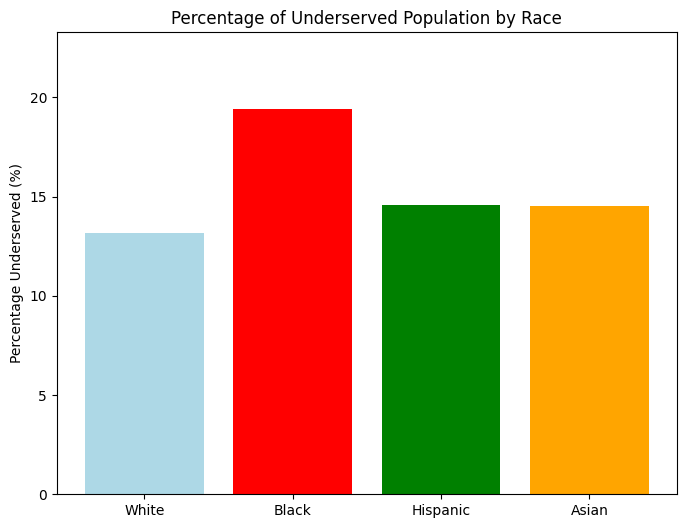

In [41]:
# Labels and values
groups = ['White', 'Black', 'Hispanic','Asian']
values = [pct_underserved_white, pct_underserved_black, pct_underserved_hispanic,pct_underserved_asian]

# Colors (optional)
colors = ['lightblue', 'red', 'green','orange']

# Plot
plt.figure(figsize=(8,6))
plt.bar(groups, values, color=colors)
plt.ylabel("Percentage Underserved (%)")
plt.title("Percentage of Underserved Population by Race")
plt.ylim(0, max(values)*1.2)  # some space above the tallest bar
plt.show()

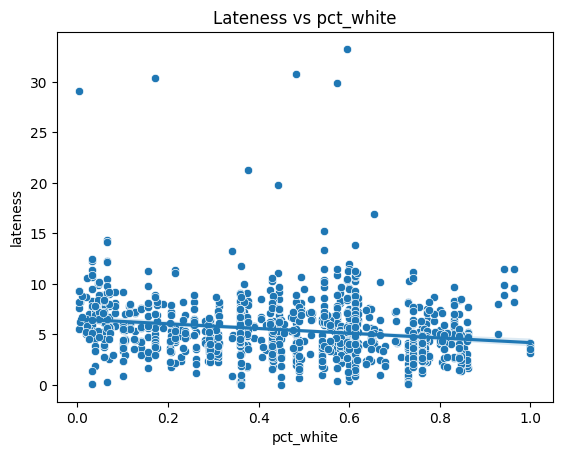

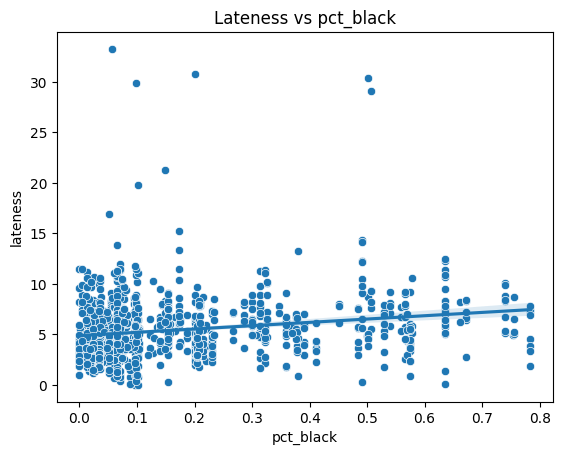

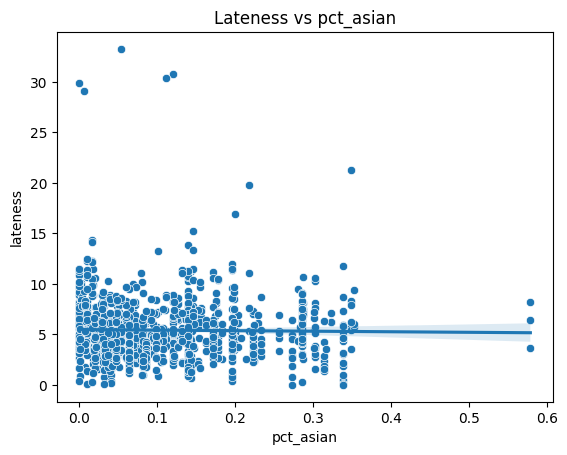

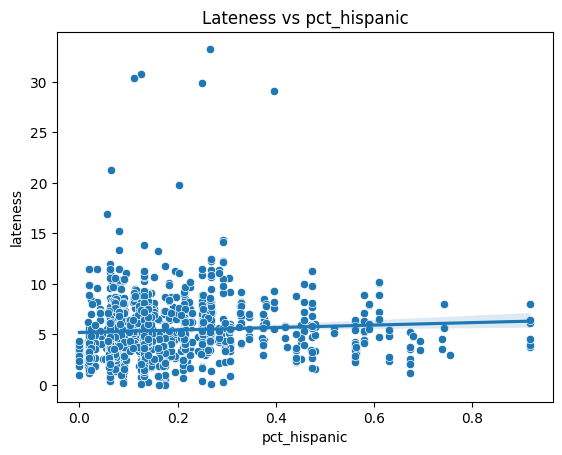

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

demo_cols = ["pct_white", "pct_black", "pct_asian", "pct_hispanic"]

for col in demo_cols:
    sns.scatterplot(data=lateness_demo, x=col, y="lateness")
    sns.regplot(data=lateness_demo, x=col, y="lateness", scatter=False)  # trend line
    plt.title(f"Lateness vs {col}")
    plt.show()


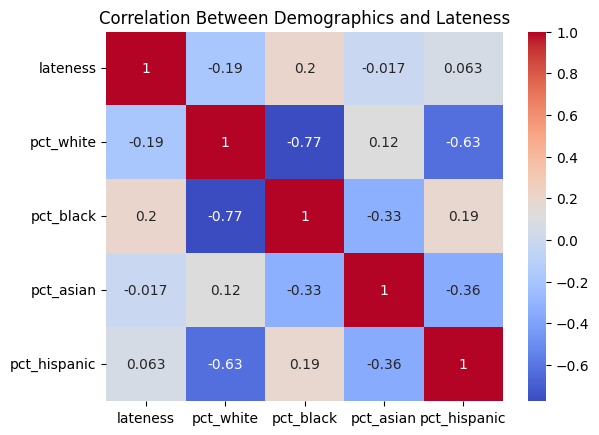

In [43]:
corr = lateness_demo[["lateness","pct_white","pct_black","pct_asian","pct_hispanic"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Demographics and Lateness")
plt.show()


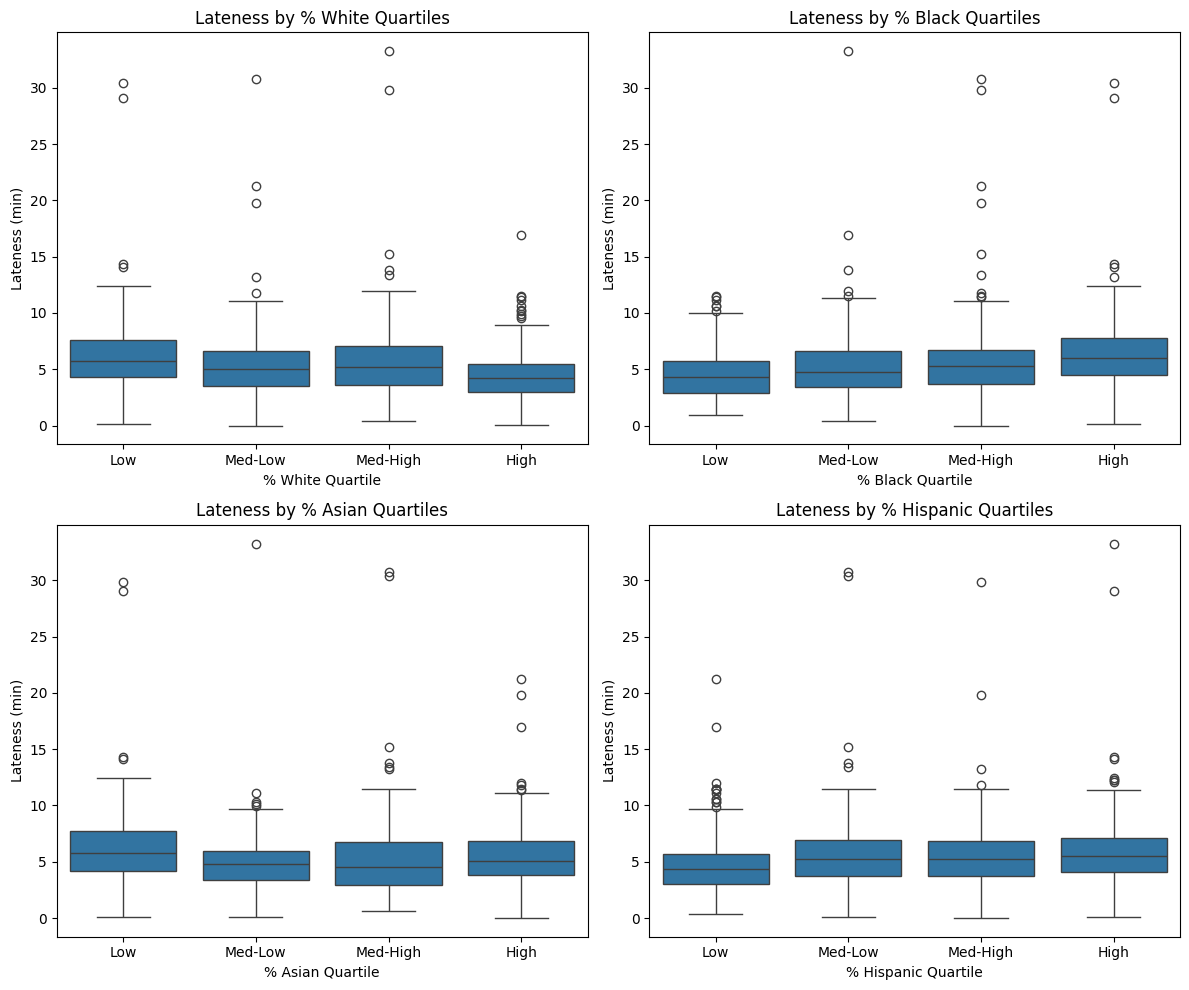

In [44]:
demo_cols = ["pct_white", "pct_black", "pct_asian", "pct_hispanic"]
labels = ["White", "Black", "Asian", "Hispanic"]

# Create quartile bins for each race
for col in demo_cols:
    lateness_demo[col + "_bin"] = pd.qcut(lateness_demo[col], q=4,
                                          labels=["Low","Med-Low","Med-High","High"])

# 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, col, label in zip(axes.flatten(), demo_cols, labels):
    sns.boxplot(
        data=lateness_demo,
        x=col + "_bin",
        y="lateness",
        ax=ax
    )
    ax.set_title(f"Lateness by % {label} Quartiles")
    ax.set_xlabel(f"% {label} Quartile")
    ax.set_ylabel("Lateness (min)")

plt.tight_layout()
plt.show()

In [45]:
route_demo = lateness_demo.groupby("route_id").agg({
    "lateness": "mean",
    "scheduled_headway": "mean",
    "pct_white": "mean",
    "pct_black": "mean",
    "pct_asian": "mean",
    "pct_hispanic": "mean"
}).reset_index()

C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\1396369124.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  route_demo = lateness_demo.groupby("route_id").agg({


In [46]:
lateness_demo.head()

,route_id,stop_id,lateness,scheduled_headway,pct_white,pct_black,pct_asian,pct_hispanic,B03002_001E,B03002_003E,B03002_004E,B03002_006E,B03002_012E,pct_white_bin,pct_black_bin,pct_asian_bin,pct_hispanic_bin
0,01,2,5.184662,775.287403,0.057253,0.314571,0.038598,0.580251,3109.0,178.0,978.0,120.0,1804.0,Low,High,Med-Low,High
13,01,59,8.624564,793.700574,0.545237,0.172964,0.145556,0.081426,3758.0,2049.0,650.0,547.0,306.0,Med-High,Med-High,Med-High,Med-Low
14,01,62,8.932083,793.462834,0.057253,0.314571,0.038598,0.580251,3109.0,178.0,978.0,120.0,1804.0,Low,High,Med-Low,High
15,01,64,5.391084,781.704581,0.358454,0.154289,0.285284,0.138942,3649.0,1308.0,563.0,1041.0,507.0,Med-Low,Med-High,High,Med-Low
20,01,79,8.279389,793.669493,0.580009,0.054912,0.175032,0.110682,4662.0,2704.0,256.0,816.0,516.0,Med-High,Med-Low,High,Med-Low


In [47]:
demo_cols = ["pct_white", "pct_black", "pct_asian", "pct_hispanic"]

for col in demo_cols:
    route_demo[col + "_bin"] = pd.qcut(
        route_demo[col],
        q=4,
        labels=["Low", "Med-Low", "Med-High", "High"]
    )


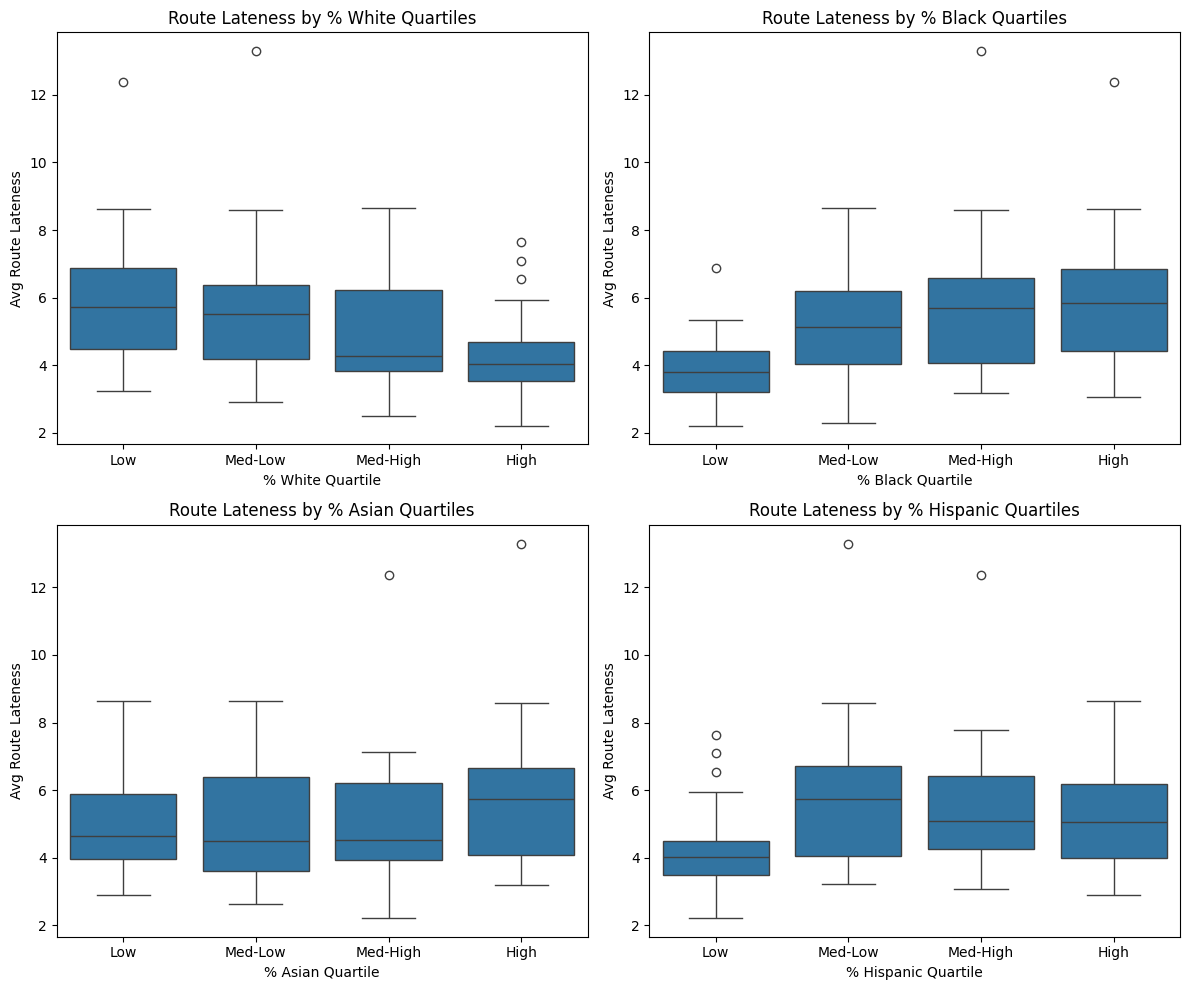

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["White", "Black", "Asian", "Hispanic"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, col, label in zip(axes.flatten(), demo_cols, labels):
    sns.boxplot(
        data=route_demo,
        x=col + "_bin",
        y="lateness",
        ax=ax
    )
    ax.set_title(f"Route Lateness by % {label} Quartiles")
    ax.set_xlabel(f"% {label} Quartile")
    ax.set_ylabel("Avg Route Lateness")

plt.tight_layout()
plt.show()


Compute Non-white percentage

In [49]:
lateness_demo["pct_nonwhite"] = 1 - lateness_demo["pct_white"]


Aggregate to Route-Level

In [50]:
route_equity = lateness_demo.groupby("route_id").agg({
    "lateness": "mean",
    "pct_white": "mean",
    "pct_nonwhite": "mean"
}).reset_index()

C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\1225703097.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  route_equity = lateness_demo.groupby("route_id").agg({


Classify Routes: “Majority White” vs. “Majority Non-White”

In [51]:
route_equity["race_group"] = route_equity["pct_white"].apply(
    lambda x: "Majority White" if x > 0.5 else "Majority Non-White"
)

Compare Lateness Between These Two Groups

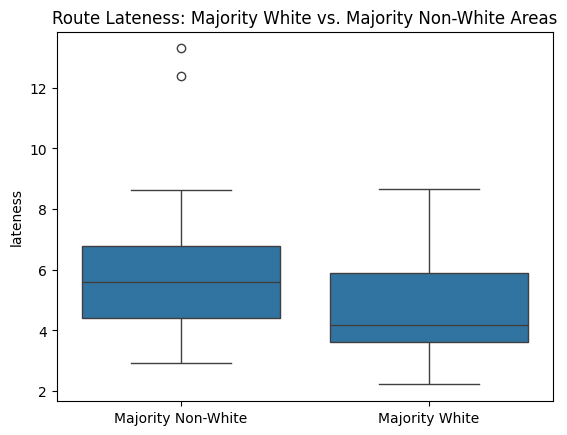

In [52]:
sns.boxplot(data=route_equity, x="race_group", y="lateness")
plt.title("Route Lateness: Majority White vs. Majority Non-White Areas")
plt.xlabel("")
plt.show()

Rank which routes serve minorities the most

In [53]:
routes_most_nonwhite = route_equity.sort_values("pct_nonwhite", ascending=False)
routes_most_nonwhite.head(10)

,route_id,lateness,pct_white,pct_nonwhite,race_group
57,245,7.380987,0.039096,0.960904,Majority Non-White
60,29,8.633963,0.119085,0.880915,Majority Non-White
88,44,7.109206,0.182593,0.817407,Majority Non-White
51,23,6.945541,0.186996,0.813004,Majority Non-White
64,33,4.406507,0.196811,0.803189,Majority Non-White
59,28,7.773622,0.197550,0.802450,Majority Non-White
55,24,6.787711,0.216357,0.783643,Majority Non-White
62,31,4.810580,0.216753,0.783247,Majority Non-White
58,26,3.577079,0.234510,0.765490,Majority Non-White
91,45,12.378683,0.275973,0.724027,Majority Non-White


Which routes most affect minorities

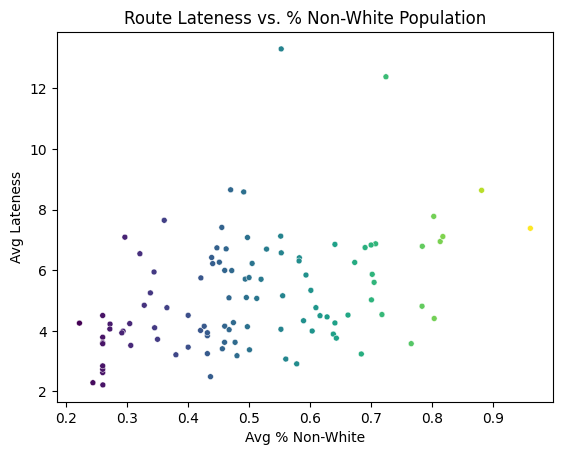

In [54]:
sns.scatterplot(
    data=route_equity,
    x="pct_nonwhite",
    y="lateness",
    hue="pct_nonwhite",
    palette="viridis",
    size=3,
    legend=False
)
plt.title("Route Lateness vs. % Non-White Population")
plt.xlabel("Avg % Non-White")
plt.ylabel("Avg Lateness")
plt.show()


Top 15 routes serving minority areas:

In [55]:
routes_most_nonwhite[["route_id","pct_nonwhite","lateness"]].head(15)

,route_id,pct_nonwhite,lateness
57,245,0.960904,7.380987
60,29,0.880915,8.633963
88,44,0.817407,7.109206
51,23,0.813004,6.945541
64,33,0.803189,4.406507
59,28,0.802450,7.773622
55,24,0.783643,6.787711
62,31,0.783247,4.810580
58,26,0.765490,3.577079
91,45,0.724027,12.378683


Top routes with high lateness and high non-white population:

In [56]:
route_equity.assign(
    score = route_equity["pct_nonwhite"] * route_equity["lateness"]
).sort_values("score", ascending=False).head(15)

,route_id,lateness,pct_white,pct_nonwhite,race_group,score
91,45,12.378683,0.275973,0.724027,Majority Non-White,8.962498
60,29,8.633963,0.119085,0.880915,Majority Non-White,7.605791
111,600,13.296432,0.447767,0.552233,Majority Non-White,7.342725
57,245,7.380987,0.039096,0.960904,Majority Non-White,7.092423
59,28,7.773622,0.197550,0.802450,Majority Non-White,6.237940
88,44,7.109206,0.182593,0.817407,Majority Non-White,5.811115
51,23,6.945541,0.186996,0.813004,Majority Non-White,5.646755
55,24,6.787711,0.216357,0.783643,Majority Non-White,5.319142
17,114,6.869592,0.292936,0.707064,Majority Non-White,4.857241
30,17,6.830264,0.300314,0.699686,Majority Non-White,4.779037


Compare lateness ranking and non-white ranking together:

In [57]:
route_equity.sort_values("pct_nonwhite", ascending=False)[["route_id","lateness","pct_nonwhite"]].head(10)


,route_id,lateness,pct_nonwhite
57,245,7.380987,0.960904
60,29,8.633963,0.880915
88,44,7.109206,0.817407
51,23,6.945541,0.813004
64,33,4.406507,0.803189
59,28,7.773622,0.802450
55,24,6.787711,0.783643
62,31,4.810580,0.783247
58,26,3.577079,0.765490
91,45,12.378683,0.724027


In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# tracts is your census data GeoDataFrame
boston_tracts["group"] = np.where(
    boston_tracts["pct_white"] >= 0.5,
    "Majority White",
    "Majority Non-White"
)


In [60]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString


shapes = pd.read_csv("../../data/MBTA_GTFS/shapes.txt")
trips = pd.read_csv("../../data/MBTA_GTFS/trips.txt")

# Make a LineString for each shape_id
shape_lines = (
    shapes.sort_values(["shape_id", "shape_pt_sequence"])
          .groupby("shape_id")
          .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))

        .reset_index(name="geometry")
)

shape_route_map = trips[["shape_id", "route_id"]].drop_duplicates()
routes_gdf = gpd.GeoDataFrame(shape_lines, geometry="geometry", crs="EPSG:4326")

routes_gdf = routes_gdf.merge(shape_route_map, on="shape_id", how="left")


print(routes_gdf.columns)



routes_gdf = routes_gdf.merge(
    lateness_demo,
    on="route_id",
    how="left"
)

shape_lines = (
    shapes.sort_values(["shape_id", "shape_pt_sequence"])
          .groupby("shape_id")
          .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))
          .reset_index(name="geometry")
)



C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\3634335064.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))


Index(['shape_id', 'geometry', 'route_id'], dtype='object')


C:\Users\hanna\AppData\Local\Temp\ipykernel_19324\3634335064.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))


Clip routes to Boston bounds

In [61]:
from shapely.geometry import box

# Create a bounding box for Boston tracts
minx, miny, maxx, maxy = boston_tracts.total_bounds
boston_bbox = box(minx, miny, maxx, maxy)

# Clip routes to Boston
routes_gdf = routes_gdf.clip(boston_bbox)

routes_gdf = routes_gdf[routes_gdf.intersects(boston_bbox)]

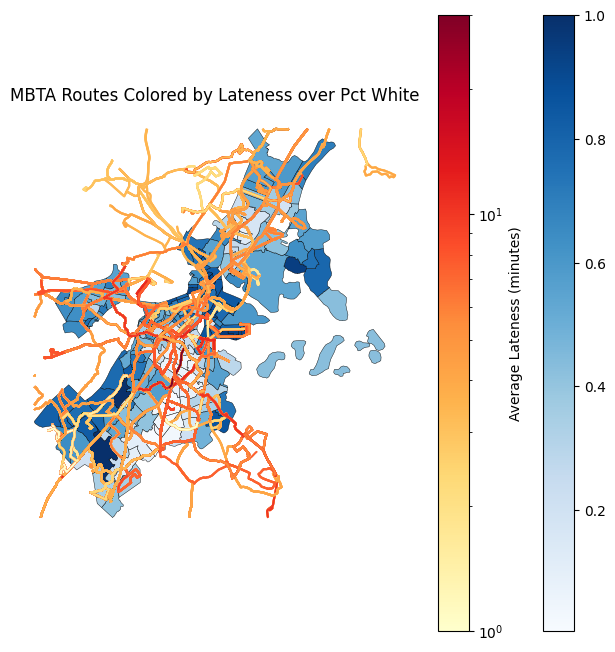

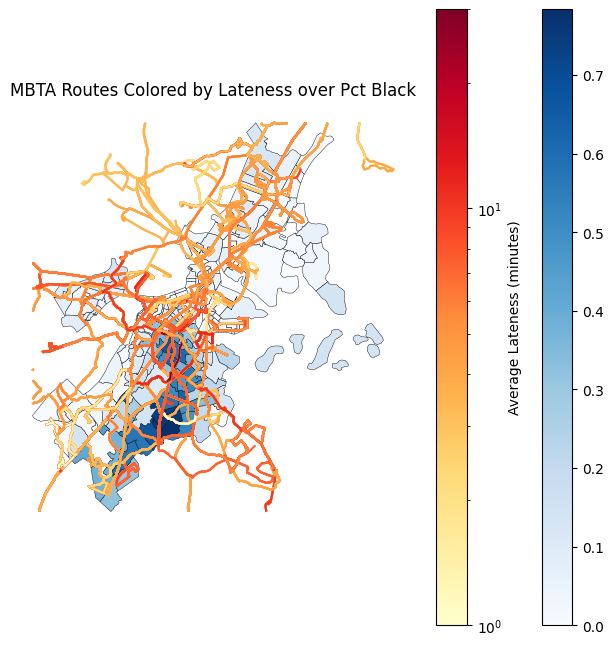

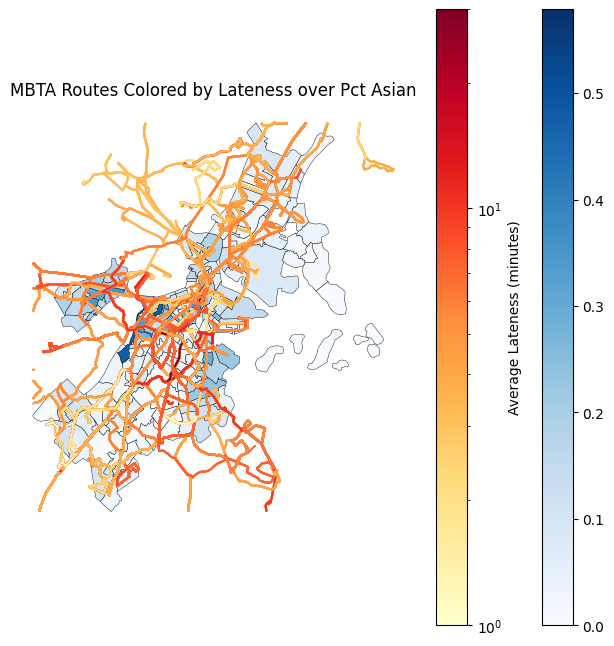

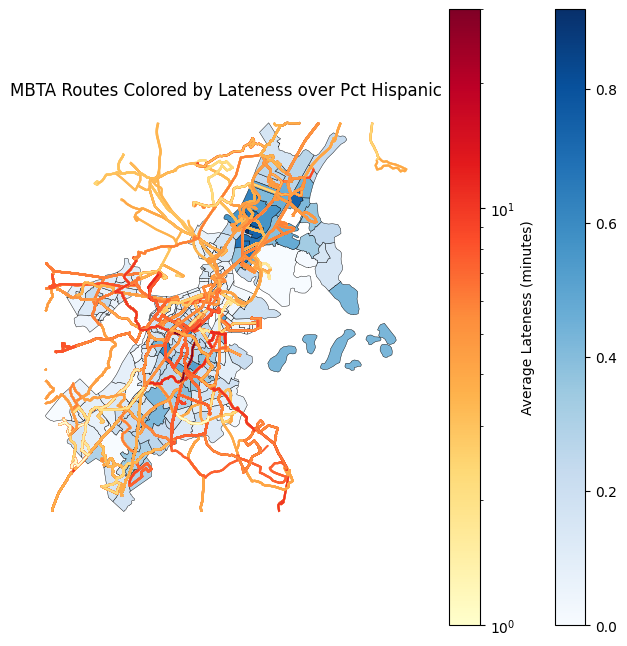

In [62]:
import matplotlib.colors as colors
# 1. Ensure routes CRS matches tracts CRS
routes_gdf = routes_gdf.set_crs("EPSG:4326")  # if not already
routes_gdf = routes_gdf.to_crs(boston_tracts.crs)

for col in demo_cols:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot demographic layer
    boston_tracts.plot(
        column=col,
        cmap="Blues",
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.3
    )

    # Plot lateness on top
    routes_gdf.plot(
        column="lateness",
        ax=ax,
        linewidth=1.5,
        cmap="YlOrRd",
        legend=True,
        norm=colors.LogNorm(vmin=1, vmax=30),
        legend_kwds={"label": "Average Lateness (minutes)"}
    )

    plt.title(f"MBTA Routes Colored by Lateness over {col.replace('_',' ').title()}")
    plt.axis("off")
    plt.show()

In [63]:

stops_gdf_lateness = stops_gdf.merge(lateness_demo, on="stop_id", how="left")


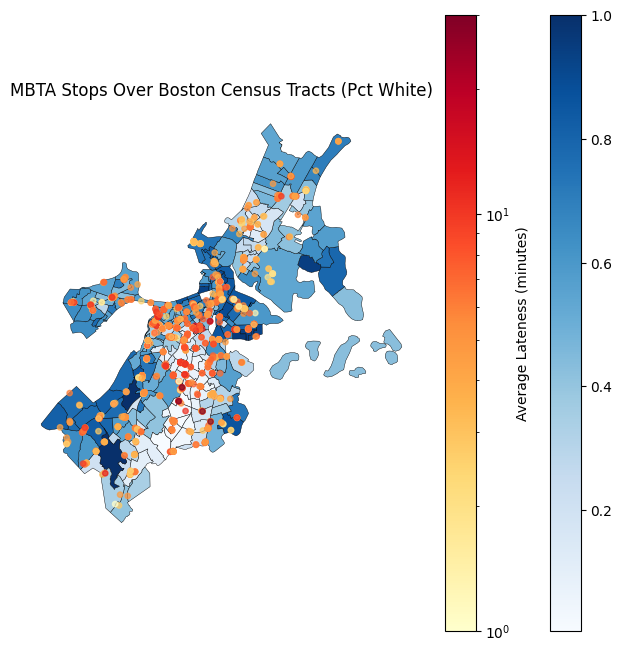

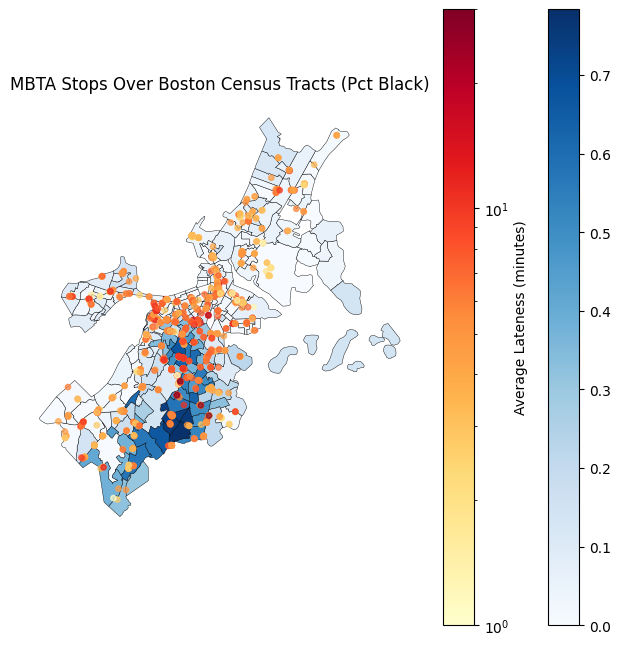

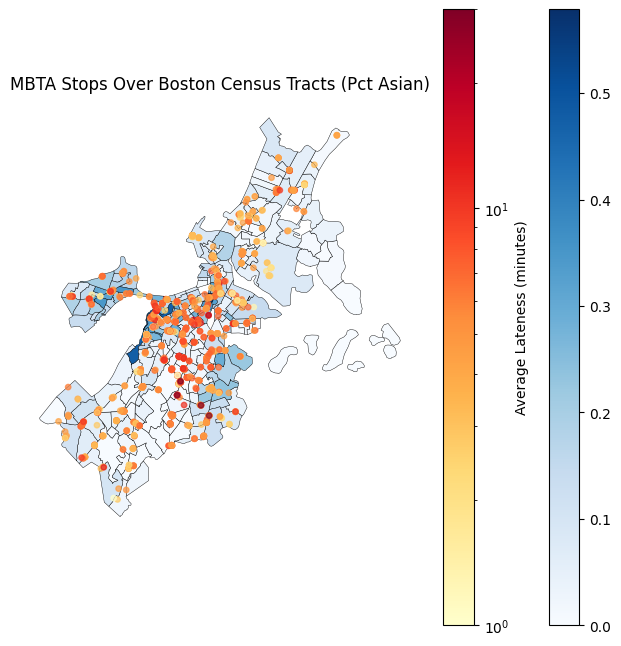

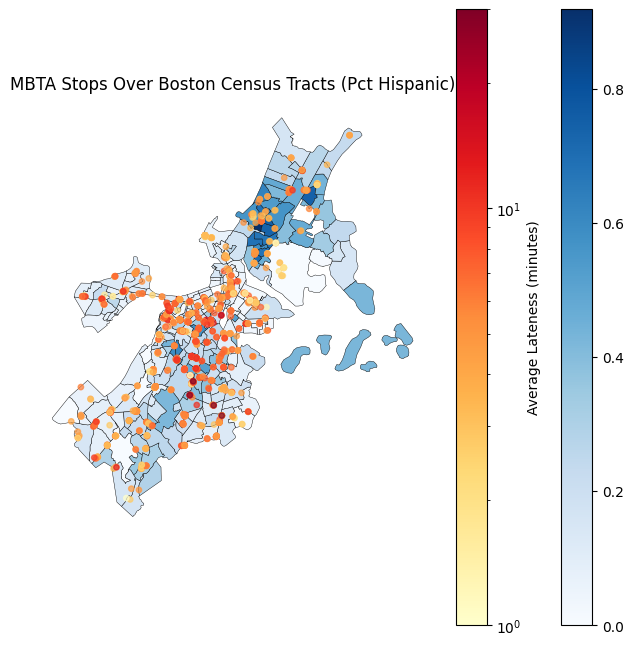

In [64]:
for col in demo_cols:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Background: Census tracts by demographics
    boston_tracts.plot(
        column=col,
        cmap="Blues",
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.3
    )

    # Stop-level lateness overlay
    stops_gdf_lateness.plot(
        ax=ax,
        column="lateness",
        cmap="YlOrRd",
        markersize=15,
        alpha=0.7,
        legend=True,
        norm=colors.LogNorm(vmin=1, vmax=30),
        legend_kwds={"label": "Average Lateness (minutes)"}
    )

    plt.title(f"MBTA Stops Over Boston Census Tracts ({col.replace('_',' ').title()})")
    plt.axis("off")
    plt.show()
